![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

# Base + Type + Conala + Embedding + Augmentation + gradient=True

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp '/content/drive/My Drive/nlp_capstone/english_to_python-train.txt' .
! cp '/content/drive/My Drive/nlp_capstone/english_to_python-test.txt' .
! cp '/content/drive/My Drive/nlp_capstone/combined_dataset_vocab_300_english.pkl' .
! cp '/content/drive/My Drive/nlp_capstone/combined_dataset_vocab_300_python.pkl' .
! cp '/content/drive/My Drive/nlp_capstone/glove_combined_300_english.pt' .
! cp '/content/drive/My Drive/nlp_capstone/glove_combined_300_python.pt' .

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 6435

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en')

In [ ]:
import traceback
import tokenize
import io
import keyword

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_python(text):
    """
    Tokenizes Python Code to list of strings
    """
    python_token_list = []
    raised_exception = False
    try:
        tokens = tokenize.tokenize(io.BytesIO(text.encode('utf-8')).readline)
        for five_tuple in tokens:
            if five_tuple.type == tokenize.COMMENT:
                continue
            elif five_tuple.type == tokenize.ENCODING:
                continue
            elif five_tuple.type == tokenize.INDENT:
                python_token_list.append("INDENT")
            elif five_tuple.type == tokenize.DEDENT:
                python_token_list.append("DEDENT")
            elif five_tuple.type == tokenize.NL or five_tuple.type == tokenize.NEWLINE:
                python_token_list.append("NEWLINE")
            elif five_tuple.type == tokenize.ENDMARKER :
                continue
            else:
                python_token_list.append(five_tuple.string)
    except Exception:
        raised_exception = True        
        print( "Exception: ", Exception, " program: ", text)
        traceback.print_exc()
    return python_token_list

def tokenize_python_type(text):
    """
    Tokenizes Python Code to list of strings representing type
    """
    python_type_list = []
    raised_exception = False
    last_token = ''
    i = 0
    try:
        tokens = tokenize.tokenize(io.BytesIO(text.encode('utf-8')).readline)
        for five_tuple in tokens:
            i += 1
            # print(i)
            if last_token == '(' and len(python_type_list) > 0 and  python_type_list[-1] == tokenize.NAME:
                python_type_list[-1] = 'FUNCTION'

            if five_tuple.type == tokenize.COMMENT:
                last_token = ''
                continue
            elif five_tuple.type == tokenize.ENCODING:
                last_token = ''
                continue
            elif five_tuple.type == tokenize.INDENT:                
                python_type_list.append("INDENT")
                last_token = ''
            elif five_tuple.type == tokenize.DEDENT:                
                python_type_list.append("DEDENT")
                last_token = ''
            elif five_tuple.type == tokenize.NL or five_tuple.type == tokenize.NEWLINE:
                python_type_list.append("NEWLINE")
                last_token = ''
            elif five_tuple.type == tokenize.ENDMARKER :
                last_token = ''
                continue
            elif five_tuple.type == tokenize.NAME:                
                if keyword.iskeyword(five_tuple.string):
                    python_type_list.append("KEYWORD")
                elif five_tuple.string.isidentifier():
                    python_type_list.append("IDENTIFIER")
                elif last_token == 'def':
                    python_type_list.append("FUNCTION_DECLARATION")
                else:
                    python_type_list.append('NAME')
                last_token = five_tuple.string
            else:
                python_type_list.append(tokenize.tok_name[five_tuple.type])
                last_token = five_tuple.string          

    except Exception:
        raised_exception = True
        print( "Exception: ", Exception, " program: ", text)
        traceback.print_exc()
    return python_type_list

In [ ]:
import nltk
import string
import re

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import string
import nltk
import random
import random
#import google_trans_new
#from google_trans_new import google_translator

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
lem = WordNetLemmatizer()
#translator = google_translator()

def clean_text(text):
    ## lower case
    if not isinstance(text, str):
      return str(text) 
    cleaned = text.lower()

    urls_pattern = re.compile(r'https?://\S+|www.\S+')
    cleaned = urls_pattern.sub(r'',cleaned)
    
    ## remove punctuations
    punctuations = string.punctuation
    cleaned_temp = "".join(character for character in cleaned if character not in punctuations)
    
    ## remove stopwords 
    words = cleaned_temp.split()
    #stopword_lists = stopwords.words("english")
    #cleaned = [word for word in words if word not in stopword_lists]
    cleaned = words
    
    ## normalization - lemmatization
    #cleaned = [lem.lemmatize(word, "v") for word in cleaned]
    #cleaned = [lem.lemmatize(word, "n") for word in cleaned]
    
    ## join 
    cleaned = " ".join(cleaned)
    return cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from nltk.corpus import wordnet

synonyms = []

for syn in wordnet.synsets("Soil"):
    for lm in syn.lemmas():
             synonyms.append(lm.name())
print (set(synonyms))

{'grunge', 'filth', 'begrime', 'stain', 'grease', 'bemire', 'grime', 'land', 'soil', 'colly', 'territory', 'dirt', 'ground', 'dirty'}


In [ ]:
!pip install google_trans_new

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import string
import nltk
import random
import random
import google_trans_new
from google_trans_new import google_translator

def back_translate(sentence):
  
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  #print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")
  translator = google_translator()
  translations = translator.translate(text=sentence, lang_src='en', lang_tgt=trans_lang) 
  #print(translations)

  translations_en_random = translator.translate(text=translations, lang_src=trans_lang, lang_tgt='en') 
  # print(translations_en_random)
  return translations_en_random

def random_deletion(sentence, p=0.5): 
    words = sentence.split()
    ret_val = ""
    if len(words) == 1: # return if single word
        ret_val = words
        return ret_val
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        ret_val = [random.choice(words)] 
    else:
        ret_val = remaining
    return " ".join(ret_val)

def random_swap(sentence, n=5):
    words =  sentence.split()
    length_words = len(words)
    if length_words < 2:
        return  sentence
    length = range(length_words)

    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        words[idx1], words[idx2] = words[idx2], words[idx1] 
    return " ".join(words)

In [ ]:
def synonym_word(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lm in syn.lemmas():
            synonyms.append(lm.name())
    if len(synonyms) <=0:
        return word
    return random.sample(synonyms, 1)[0]


In [ ]:
def synonym_sentence(sentence, prob=0.5):
    words =  sentence.split()
    synonym_words = []
    for word in words:
        if random.random() < prob:
            synonym_words.append(synonym_word(word))
        else:
            synonym_words.append(word)
    return " ".join(synonym_words)

In [ ]:
print(synonym_sentence("This is my country India. I very much love my country"))

This is my country India. I identical much love my state


In [ ]:
train_english_text_python_program_pair_list = []
process_python_code=False
i=1
with open('english_to_python-train.txt', 'r', encoding="utf8") as f:
#with open('updated_sample_clean_dataset.txt', 'r', encoding="utf8") as f:
    for line in f:
        #print(i)
        i += 1
        if process_python_code==False:
            if line.strip() == '':
                continue
            if line.startswith('#'):
                english_text = line
                #english_text_list.append(line)
                process_python_code=True
                python_program=''
            else:
                print(i, ": ", line)            
        else:
            if line.strip() == '':
                process_python_code=False
                train_english_text_python_program_pair_list.append((english_text, python_program))
                python_program=''
                english_text =''
            if line.lstrip().startswith('#') or line.lstrip().startswith('import'):
                continue
            else:
                python_program += line

In [ ]:
test_english_text_python_program_pair_list = []
process_python_code=False
i=1
with open('english_to_python-test.txt', 'r', encoding="utf8") as f:
#with open('updated_sample_clean_dataset.txt', 'r', encoding="utf8") as f:
    for line in f:
        #print(i)
        i += 1
        if process_python_code==False:
            if line.strip() == '':
                continue
            if line.startswith('#'):
                english_text = line
                #english_text_list.append(line)
                process_python_code=True
                python_program=''
            else:
                print(i, ": ", line)            
        else:
            if line.strip() == '':
                process_python_code=False
                test_english_text_python_program_pair_list.append((english_text, python_program))
                python_program=''
                english_text =''
            if line.lstrip().startswith('#') or line.lstrip().startswith('import'):
                continue
            else:
                python_program += line

In [ ]:
train_english_text_list,train_python_program_list  = zip(*train_english_text_python_program_pair_list)
test_english_text_list,test_python_program_list  = zip(*test_english_text_python_program_pair_list)

In [ ]:
import pandas as pd

df = pd.DataFrame({'English': train_english_text_list, 'Python':train_python_program_list })
test_df = pd.DataFrame({'English': test_english_text_list, 'Python':test_python_program_list })

In [ ]:
from tqdm import tqdm_notebook as tqdm
tqdm().pandas() 

df['English'] = df['English'].progress_apply(lambda txt: clean_text(txt))
test_df['English'] = test_df['English'].progress_apply(lambda txt: clean_text(txt))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
df['Python'] = df['Python'].progress_apply(lambda txt: txt.lstrip())
test_df['Python'] = test_df['Python'].progress_apply(lambda txt: txt.lstrip())

In [ ]:
df.head(10)

,English,Python
0,python program to calculate simple interest,"princ_amount = float(input("" Please Enter the ..."
1,sort the list in descending order,"my_list = [4,3,2,9,10,44,1]\nmy_list.sort(reve..."
2,write a function to return the volume of a cone,"def cal_cone_volume(height,radius):\n pi=3...."
3,write a python function to generate amortizati...,"def loan_schedule(principal, interest_rate, an..."
4,write a python program to shuffle and print a ...,"deck = list(itertools.product(range(1,14),['Sp..."
5,with a given tuple 12345678910 write a program...,"tp=(1,2,3,4,5,6,7,8,9,10)\ntp1=tp[:5]\ntp2=tp[..."
6,write a program using generator to print the e...,def EvenGenerator(n):\n i=0\n while i<=n...
7,write a program to find compound interest,"p = float(input(""Enter the principle amount : ..."
8,46 define a function which can generate a list...,def get_encoding(url):\n data = requests.ge...
9,write a python program for removing strings fr...,"test_list = [('Geeks', 1, 2), ('for', 4, 'Geek..."


In [ ]:
test_df.head(10)

,English,Python
0,write a function that takes a base and a power...,"def power(base,exp):\n if(exp==1):\n ..."
1,logging message,"def logging(msg, *, dt = datetime.utcnow()):\n..."
2,write a python function to get the maximum ele...,def max(list):\n return max(list)\n
3,write a python program to print the first 5 it...,"my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\npri..."
4,write a python program using all function,"print (all([False, True, False, False])) \n"
5,write a python function that finds square root...,def find_integer_square_roots(num):\n found...
6,write a program to find union of 2 arrays,"a = {1, 2, 3, 4}\nb = {3, 4, 5, 6}\nunion_both..."
7,write a python function that returns the input...,def sort_ascending(list_to_be_sorted):\n re...
8,write a python function where you take any pos...,def collatz_sequence(x):\n num_seq = [x]\n ...
9,write a python function to return carol numbers,def carol_number(n):\n if n >= 0:\n ...


In [ ]:
import random
import torch, torchtext
from torchtext import data
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.data import Field, BucketIterator, Example, Dataset

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_python, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            batch_first = True)

TRG_TYPE = Field(tokenize = tokenize_python_type, 
            init_token='<sos>', 
            eos_token='<eos>', 
            batch_first = True
            )

In [ ]:
fields = [('English', SRC),('Python',TRG),('PythonType',TRG_TYPE)]

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_data = train_test_split(df, test_size=0.05)
test_data = test_df

In [ ]:
train_augment_df = pd.DataFrame(columns=['English', 'Python'])
for index, row in train_df.iterrows():  
  train_augment_df = train_augment_df.append({'English':random_deletion(row['English']), 'Python': row['Python'] }, ignore_index=True)
  train_augment_df = train_augment_df.append({'English':random_swap(row['English']), 'Python':  row['Python']}, ignore_index=True ) 
  train_augment_df = train_augment_df.append({'English':synonym_sentence(row['English']), 'Python':  row['Python']}, ignore_index=True ) 
  if random.random() <= 0.05: 
    train_augment_df = train_augment_df.append({'English':back_translate(row['English']), 'Python':  row['Python'] }, ignore_index=True)

In [ ]:
train_data = pd.concat([train_df, train_augment_df],axis=0)

In [ ]:
train_data = train_data.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing
valid_data = valid_data.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing
test_data = test_data.reset_index(drop=True) ## This is being done because data.Example.fromlist was failing

In [ ]:
train_data

,English,Python
0,write a function to adds two lists element wis...,"def adds_listevenelements(l1:list, l2:list):\n..."
1,write a python program to add two matrices,"X = [[12,7,3],\n [4 ,5,6],\n [7 ,8,9]]\n..."
2,write a program to convert into dictionary,"def Convert(tup, di): \n for a, b in tup: \..."
3,write a program for deleting entire dictionary,"Dict = {1: 'Geeks', 'name': 'For', 3: 'Geeks'}..."
4,sort json keys in python and write it into a file,"sampleJson = {""id"" : 1, ""name"" : ""value2"", ""ag..."
...,...,...
10031,write a program which accepts a sequence of on...,"s = input()\nprint(re.findall(""\d+"",s))\n"
10032,write a program which accept A sequence of wor...,"s = input()\nprint(re.findall(""\d+"",s))\n"
10033,write function find the a tuple without,"Tuple = (10,20)\ndef sizeOfTuple(tup):\n retu..."
10034,write a a size find tuple to without python th...,"Tuple = (10,20)\ndef sizeOfTuple(tup):\n retu..."


In [ ]:
MAX_OUTPUT_SEQ_LENGTH = 250
MAX_INPUT_SEQ_LENGTH = 100

In [ ]:
example_trng = [Example.fromlist([train_data.English[i],train_data.Python[i], train_data.Python[i]], fields) for i in range(train_data.shape[0]) if len(tokenize_python(train_data.Python[i])) <= MAX_OUTPUT_SEQ_LENGTH - 4 and  len(train_data.English[i]) <= MAX_INPUT_SEQ_LENGTH-4 and len(train_data.English[i]) > 0 ] 
example_val = [Example.fromlist([valid_data.English[i],valid_data.Python[i], valid_data.Python[i]], fields) for i in range(valid_data.shape[0]) if len(tokenize_python(valid_data.Python[i])) <= MAX_OUTPUT_SEQ_LENGTH - 4 and  len(valid_data.English[i]) <= MAX_INPUT_SEQ_LENGTH-4 and len(valid_data.English[i]) > 0 ] 
example_test = [Example.fromlist([test_data.English[i],test_data.Python[i], test_data.Python[i]], fields) for i in range(test_data.shape[0]) if len(tokenize_python(test_data.Python[i])) <= MAX_OUTPUT_SEQ_LENGTH - 4 and  len(test_data.English[i]) <= MAX_INPUT_SEQ_LENGTH-4 and len(test_data.English[i] )> 0 ] 

In [ ]:
train_dataset = Dataset(example_trng, fields)
valid_dataset = Dataset(example_val, fields)
test_dataset = Dataset(example_test, fields)

In [ ]:
vars(train_dataset.examples[5])

{'English': ['write',
  'a',
  'python',
  'program',
  'that',
  'adds',
  'the',
  'elements',
  'of',
  'a',
  'list',
  'to',
  'a',
  'set',
  'and',
  'prints',
  'the',
  'set'],
 'Python': ['my_set',
  '=',
  '{',
  '1',
  ',',
  '2',
  ',',
  '3',
  '}',
  'NEWLINE',
  'my_list',
  '=',
  '[',
  '4',
  ',',
  '5',
  ',',
  '6',
  ']',
  'NEWLINE',
  'my_set',
  '.',
  'update',
  '(',
  'my_list',
  ')',
  'NEWLINE',
  'print',
  '(',
  'my_set',
  ')',
  'NEWLINE'],
 'PythonType': ['IDENTIFIER',
  'OP',
  'OP',
  'NUMBER',
  'OP',
  'NUMBER',
  'OP',
  'NUMBER',
  'OP',
  'NEWLINE',
  'IDENTIFIER',
  'OP',
  'OP',
  'NUMBER',
  'OP',
  'NUMBER',
  'OP',
  'NUMBER',
  'OP',
  'NEWLINE',
  'IDENTIFIER',
  'OP',
  'IDENTIFIER',
  'OP',
  'IDENTIFIER',
  'OP',
  'NEWLINE',
  'IDENTIFIER',
  'OP',
  'IDENTIFIER',
  'OP',
  'NEWLINE']}

In [ ]:
SRC.build_vocab(train_dataset, min_freq = 1)
TRG.build_vocab(train_dataset, min_freq = 1)
TRG_TYPE.build_vocab(train_dataset, min_freq = 1)

In [ ]:
import pickle
#with open("/content/drive/My Drive/nlp_capstone/SRC_capstone4.pkl", 'wb') as f1:
#    pickle.dump(SRC.vocab.stoi, f1)

#with open("/content/drive/My Drive/nlp_capstone/TRG_capstone4.pkl", 'wb') as f2:
#    pickle.dump(TRG.vocab.stoi, f2)

#with open("/content/drive/My Drive/nlp_capstone/TRG_TYPE_capstone4.pkl", 'wb') as f3:
#    pickle.dump(TRG_TYPE.vocab.stoi, f3)

In [ ]:
import json

with open("/content/drive/My Drive/nlp_capstone/SRC_stoi_capstone7.json", "w") as fj1:
    fj1.write(json.dumps(dict(SRC.vocab.stoi)))

with open("/content/drive/My Drive/nlp_capstone/TRG_stoi_capstone7.json", "w") as fj2:
    fj2.write(json.dumps(dict(TRG.vocab.stoi)))

with open("/content/drive/My Drive/nlp_capstone/TRG_TYPE_stoi_capstone7.json", "w") as fj3:
    fj3.write(json.dumps(dict(TRG_TYPE.vocab.stoi)))

In [ ]:
src_itos = { i:s for (i,s ) in enumerate(SRC.vocab.itos)}
trg_itos = { i:s for (i,s ) in enumerate(TRG.vocab.itos)}
trg_type_itos = { i:s for (i,s ) in enumerate(TRG_TYPE.vocab.itos)}

In [ ]:
with open("/content/drive/My Drive/nlp_capstone/SRC_itos_capstone7.json", "w") as fj_itos_1:
    fj_itos_1.write(json.dumps(src_itos))

with open("/content/drive/My Drive/nlp_capstone/TRG_itos_capstone7.json", "w") as fj_itos_2:
    fj_itos_2.write(json.dumps(trg_itos))

with open("/content/drive/My Drive/nlp_capstone/TRG_TYPE_itos_capstone7.json", "w") as fj_itos_3:
    fj_itos_3.write(json.dumps(trg_type_itos))

In [ ]:
SRC.vocab.itos

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'a',
 'to',
 'write',
 'python',
 'program',
 'the',
 'of',
 'function',
 'list',
 'and',
 'in',
 'print',
 'number',
 'string',
 'given',
 'find',
 'that',
 'from',
 'two',
 'numbers',
 'is',
 'using',
 'return',
 'if',
 'convert',
 'check',
 'dictionary',
 'for',
 'all',
 'value',
 'it',
 'or',
 'an',
 'with',
 'calculate',
 'remove',
 'input',
 'by',
 'elements',
 'element',
 'tuple',
 'returns',
 'sum',
 'n',
 'length',
 'count',
 'into',
 'tuples',
 'between',
 'sort',
 'lists',
 'which',
 'user',
 'add',
 'not',
 'character',
 'get',
 'first',
 'words',
 'area',
 'even',
 'are',
 'as',
 'random',
 'values',
 'generate',
 'programme',
 'code',
 'each',
 'class',
 'provided',
 'create',
 'prints',
 'integer',
 'key',
 'takes',
 'demonstrate',
 'digits',
 'file',
 'reverse',
 'characters',
 'how',
 'time',
 'binary',
 'strings',
 'every',
 'comprehension',
 'keys',
 'word',
 'date',
 'item',
 '2',
 'whether',
 'times',
 'use',
 'on',
 'senten

In [ ]:
type(SRC.vocab.itos)

list

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BATCH_SIZE=128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x:len(x.English),
    sort_within_batch = False, 
    device = device)

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        #src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        src = (self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim,
                 output_type_dim,  
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = MAX_OUTPUT_SEQ_LENGTH):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.type_embedding = nn.Embedding(output_type_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out1 = nn.Linear(hid_dim, output_dim)
        self.fc_out2 = nn.Linear(hid_dim, output_type_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, trg_type, enc_src, trg_mask, trg_type_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]

        tok_embed = self.tok_embedding(trg)
        type_embed = self.type_embedding(trg_type)
        pos_embed = self.pos_embedding(pos)

            
        #trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = self.dropout((tok_embed*self.scale) + type_embed +  pos_embed)
        trg = (tok_embed*self.scale) + type_embed +  pos_embed
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out1(trg)
        output_type = self.fc_out2(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, output_type, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg, trg_type):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        trg_type_mask = trg_mask
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, output_type, attention = self.decoder(trg, trg_type, enc_src, trg_mask, trg_type_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, output_type, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
OUTPUT_TYPE_DIM = len(TRG_TYPE.vocab)
HID_DIM = 300
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 6
DEC_HEADS = 6
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM,
              OUTPUT_TYPE_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
SRC_UNK_IDX = SRC.vocab.stoi[SRC.unk_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]
TRG_TYPE_PAD_IDX = TRG_TYPE.vocab.stoi[TRG_TYPE.pad_token]
TRG_TYPE_UNK_IDX = TRG_TYPE.vocab.stoi[TRG_TYPE.unk_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,393,421 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
import pickle
source_dict_english = None
with open('combined_dataset_vocab_300_english.pkl',  'rb' ) as f:
    source_dict_english = pickle.load(f)

In [ ]:
import pickle
target_dict_python = None
with open('combined_dataset_vocab_300_python.pkl',  'rb' ) as f:
    target_dict_python = pickle.load(f)

In [ ]:
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x

In [ ]:
glove_model_english = GloveModel(len(source_dict_english ), ENC_EMB_DIM)
#map_location=torch.device('cpu')
#glove_model.load_state_dict(torch.load('glove_combined_300.pt', map_location))
glove_model_english.load_state_dict(torch.load('glove_combined_300_english.pt'))

<All keys matched successfully>

In [ ]:
source_glove_state_dict = glove_model_english.state_dict()
for token in SRC.vocab.stoi:
    token_id_glove_embedding = source_dict_english.get(token)
    if token_id_glove_embedding is not None:
        enc.tok_embedding.weight.data[SRC.vocab.stoi[token]] = source_glove_state_dict['wi.weight'][token_id_glove_embedding] + source_glove_state_dict['wj.weight'][token_id_glove_embedding]
    else:
        print("token: ", token, " is not present in source glove embedding")

token:  <unk>  is not present in source glove embedding
token:  <pad>  is not present in source glove embedding
token:  programme  is not present in source glove embedding
token:  ampere  is not present in source glove embedding
token:  amp  is not present in source glove embedding
token:  vitamin_a  is not present in source glove embedding
token:  type_a  is not present in source glove embedding
token:  axerophthol  is not present in source glove embedding
token:  group_a  is not present in source glove embedding
token:  angstrom  is not present in source glove embedding
token:  -  is not present in source glove embedding
token:  adenine  is not present in source glove embedding
token:  pen  is not present in source glove embedding
token:  angstrom_unit  is not present in source glove embedding
token:  publish  is not present in source glove embedding
token:  indite  is not present in source glove embedding
token:  antiophthalmic_factor  is not present in source glove embedding
token:

In [ ]:
enc.tok_embedding.weight.data[SRC_PAD_IDX] = torch.zeros(ENC_EMB_DIM)
enc.tok_embedding.weight.data[SRC_UNK_IDX] = torch.zeros(ENC_EMB_DIM)
#enc.tok_embedding.weight.requires_grad=False

In [ ]:
glove_model_python = GloveModel(len(target_dict_python), DEC_EMB_DIM)
#map_location=torch.device('cpu')
#glove_model.load_state_dict(torch.load('glove_combined_300.pt', map_location))
glove_model_python.load_state_dict(torch.load('glove_combined_300_python.pt'))

<All keys matched successfully>

In [ ]:
target_glove_state_dict = glove_model_python.state_dict()
for token in TRG.vocab.stoi:
    token_id_glove_embedding = target_dict_python.get(token)
    if token_id_glove_embedding is not None:
        dec.tok_embedding.weight.data[TRG.vocab.stoi[token]] = target_glove_state_dict['wi.weight'][token_id_glove_embedding] + target_glove_state_dict['wj.weight'][token_id_glove_embedding]
    else:
        print("token: ", token, " is not present in target glove embedding")

token:  <unk>  is not present in target glove embedding
token:  <pad>  is not present in target glove embedding
token:  matrix_1d  is not present in target glove embedding
token:  matrix_2d  is not present in target glove embedding
token:  "Johny Walker"  is not present in target glove embedding
token:  inr  is not present in target glove embedding


In [ ]:
dec.tok_embedding.weight.data[TRG_PAD_IDX] = torch.zeros(DEC_EMB_DIM)
dec.tok_embedding.weight.data[TRG_UNK_IDX] = torch.zeros(DEC_EMB_DIM)
dec.type_embedding.weight.data[TRG_TYPE_PAD_IDX] = torch.zeros(DEC_EMB_DIM)
dec.type_embedding.weight.data[TRG_TYPE_UNK_IDX] = torch.zeros(DEC_EMB_DIM)
#dec.tok_embedding.weight.requires_grad=False

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
import torch.nn.functional as F

def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean', ignore_index=-1):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction, ignore_index=self.ignore_index)
        return linear_combination(loss / n, nll, self.epsilon)

In [ ]:
#criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
criterion = LabelSmoothingCrossEntropy(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.English
        trg = batch.Python
        trg_type = batch.PythonType
        
        optimizer.zero_grad()
        
        output, output_type, _ = model(src, trg[:,:-1],  trg_type[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss1 = criterion(output, trg)

        output_type_dim = output_type.shape[-1]
            
        output_type = output_type.contiguous().view(-1, output_type_dim)
        trg_type = trg_type[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss2 = criterion(output_type, trg_type)

        loss =   3.0 * loss1 +  loss2
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.English
            trg = batch.Python
            trg_type = batch.PythonType

            output, output_type, _ = model(src, trg[:,:-1], trg_type[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss1 = criterion(output, trg)

            output_type_dim = output_type.shape[-1]
            
            output_type = output_type.contiguous().view(-1, output_type_dim)
            trg_type = trg_type[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss2 = criterion(output_type, trg_type)
            
            loss = 3.0 * loss1 +   loss2
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 100
CLIP = 1

from torch.optim.lr_scheduler import ReduceLROnPlateau
MODEL_PATH= '/content/drive/My Drive/nlp_capstone/english-python_conversion1_label_smoothing3.pt'

train_loss_list = []
valid_loss_list = []
train_ppl_list = []
valid_ppl_list = []

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_PATH )

    train_loss_list.append(train_loss)
    train_ppl_list.append(math.exp(train_loss))
    valid_loss_list.append(valid_loss)
    valid_ppl_list.append(math.exp(valid_loss))
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    scheduler.step(valid_loss)

Epoch: 01 | Time: 0m 13s
	Train Loss: 19.650 | Train PPL: 341911534.155
	 Val. Loss: 16.892 |  Val. PPL: 21687243.798
Epoch: 02 | Time: 0m 13s
	Train Loss: 14.160 | Train PPL: 1410836.960
	 Val. Loss: 12.232 |  Val. PPL: 205258.831
Epoch: 03 | Time: 0m 13s
	Train Loss: 11.717 | Train PPL: 122601.698
	 Val. Loss: 11.015 |  Val. PPL: 60759.977
Epoch: 04 | Time: 0m 13s
	Train Loss: 10.718 | Train PPL: 45170.283
	 Val. Loss: 10.365 |  Val. PPL: 31733.874
Epoch: 05 | Time: 0m 13s
	Train Loss: 10.026 | Train PPL: 22614.756
	 Val. Loss: 9.918 |  Val. PPL: 20287.049
Epoch: 06 | Time: 0m 13s
	Train Loss: 9.507 | Train PPL: 13451.130
	 Val. Loss: 9.655 |  Val. PPL: 15601.700
Epoch: 07 | Time: 0m 13s
	Train Loss: 9.040 | Train PPL: 8437.787
	 Val. Loss: 9.339 |  Val. PPL: 11378.158
Epoch: 08 | Time: 0m 13s
	Train Loss: 8.626 | Train PPL: 5572.532
	 Val. Loss: 9.038 |  Val. PPL: 8413.212
Epoch: 09 | Time: 0m 13s
	Train Loss: 8.258 | Train PPL: 3859.932
	 Val. Loss: 8.878 |  Val. PPL: 7171.175
Epoc

In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))

train_loss = evaluate(model, train_iterator, criterion)

print(f'| Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} |')

| Train Loss: 4.597 | Train PPL:  99.141 |


In [ ]:
train_loss = evaluate(model, valid_iterator, criterion)

print(f'| Validation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):7.3f} |')

| Validation Loss: 8.816 | Validation PPL: 6743.059 |


In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 8.954 | Test PPL: 7739.752 |


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_loss(train_loss_list, valid_loss_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_loss_list, label="Train Loss")
    axs.plot(valid_loss_list, label="Validation Loss")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
	
def plot_ppl(train_ppl_list, valid_ppl_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_ppl_list, label="Train Perplexity")
    axs.plot(valid_ppl_list, label="Validation Perplexity")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.show()

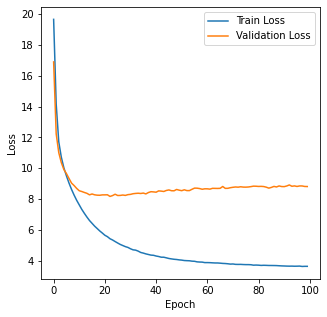

In [ ]:
plot_loss(train_loss_list, valid_loss_list)

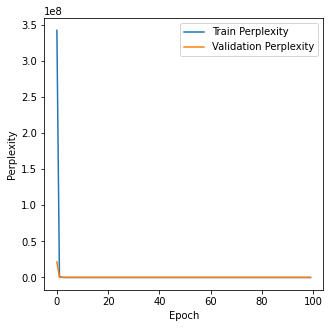

In [ ]:
plot_ppl(train_ppl_list, valid_ppl_list)

In [ ]:
def translate_sentence(sentence, src_field, trg_field, trg_type_field, model, device, max_len = 250):
    model.eval()
    sent = clean_text(" ".join(sentence))
    sentence = sent.split()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    trg_type_indexes = [trg_type_field.vocab.stoi[trg_type_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        trg_type_tensor = torch.LongTensor(trg_type_indexes).unsqueeze(0).to(device)
        trg_type_mask = trg_mask
        
        with torch.no_grad():
            output, output_type, attention = model.decoder(trg_tensor, trg_type_tensor, enc_src, trg_mask, trg_type_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    trg_type_tokens = [trg_type_field.vocab.itos[i] for i in trg_type_indexes]
    
    return trg_tokens[1:], trg_type_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 6, n_rows = 3, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads-1):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 8

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'python', 'code', 'to', 'demonstrate', 'kth', 'nonnone', 'string', 'from', 'rear', 'using', 'filter']
trg = ['test_list', '=', '[', '""', ',', '""', ',', '"Akshat"', ',', '"Nikhil"', ']', 'NEWLINE', 'print', '(', '"The original list : "', '+', 'str', '(', 'test_list', ')', ')', 'NEWLINE', 'K', '=', '2', 'NEWLINE', 'res', '=', 'list', '(', 'filter', '(', 'None', ',', 'test_list', ')', ')', '[', '-', 'K', ']', 'NEWLINE', 'print', '(', '"The Kth non empty string from rear is : "', '+', 'str', '(', 'res', ')', ')', 'NEWLINE']


In [ ]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['test_str', '=', '"geeksforgeeks"', 'NEWLINE', 'print', '(', '"The original string is : "', '+', 'str', '(', 'test_str', ')', ')', 'NEWLINE', 'test_str', '=', 'test_str', '.', 'replace', '(', 'test_str', ')', 'NEWLINE', 'res', '=', 'test_str', '.', 'replace', '(', 'test_str', ')', 'NEWLINE', 'print', '(', '"The String after performing replace : "', '+', 'str', '(', 'res', ')', ')', 'NEWLINE', '<eos>']


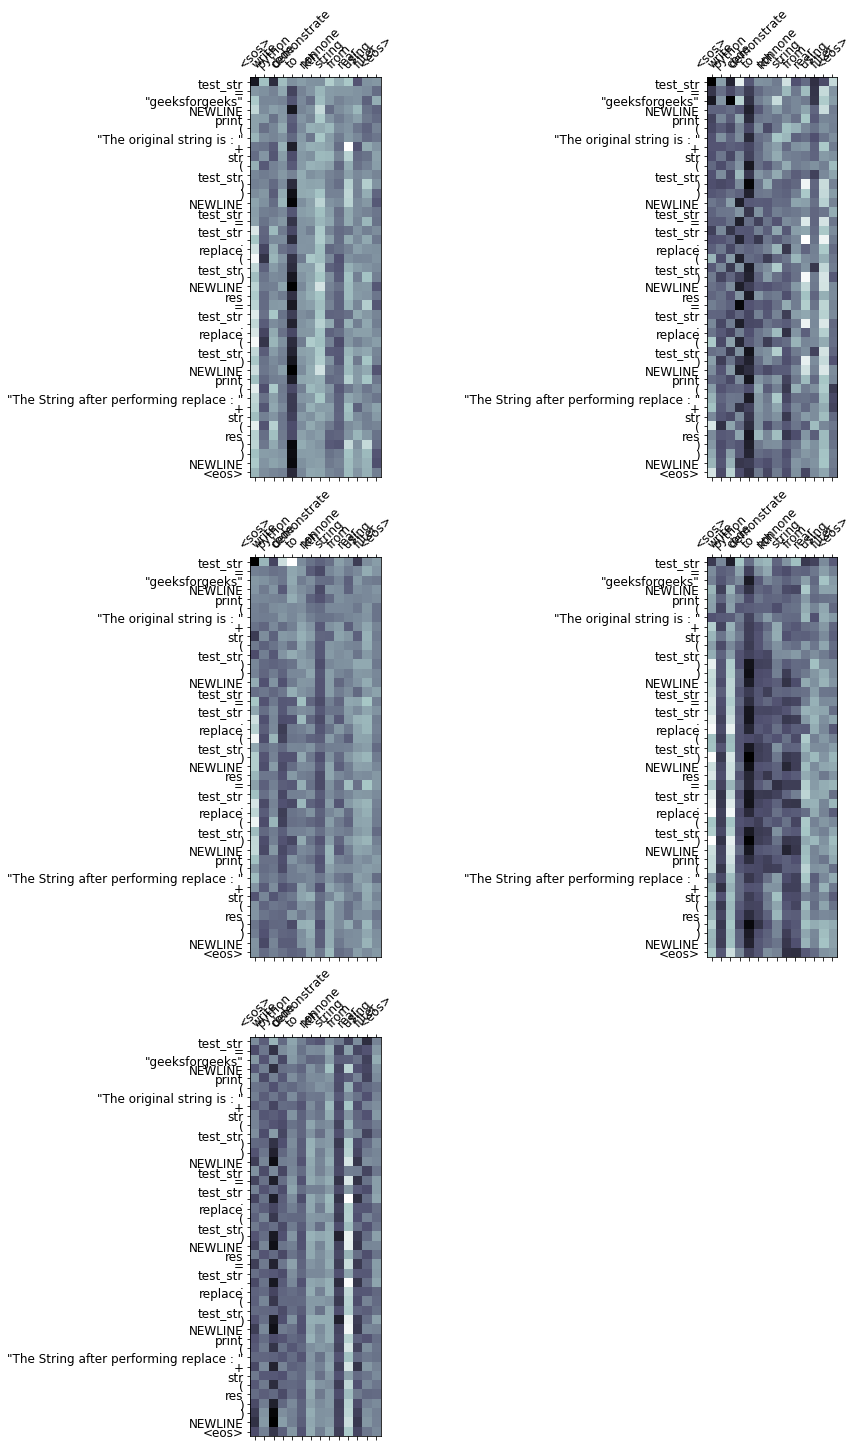

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 16

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'program', 'to', 'get', 'current', 'date', 'and', 'time']
trg = ['current_time', '=', 'datetime', '.', 'datetime', '.', 'now', '(', ')', 'NEWLINE', 'print', '(', '"Time now at greenwich meridian is : "', ',', 'end', '=', '""', ')', 'NEWLINE', 'print', '(', 'current_time', ')', 'NEWLINE']


In [ ]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['from', 'datetime', 'import', 'datetime', 'NEWLINE', 'now', '=', 'datetime', '.', 'now', '(', ')', 'NEWLINE', 'print', '(', 'now', ')', 'NEWLINE', '<eos>']


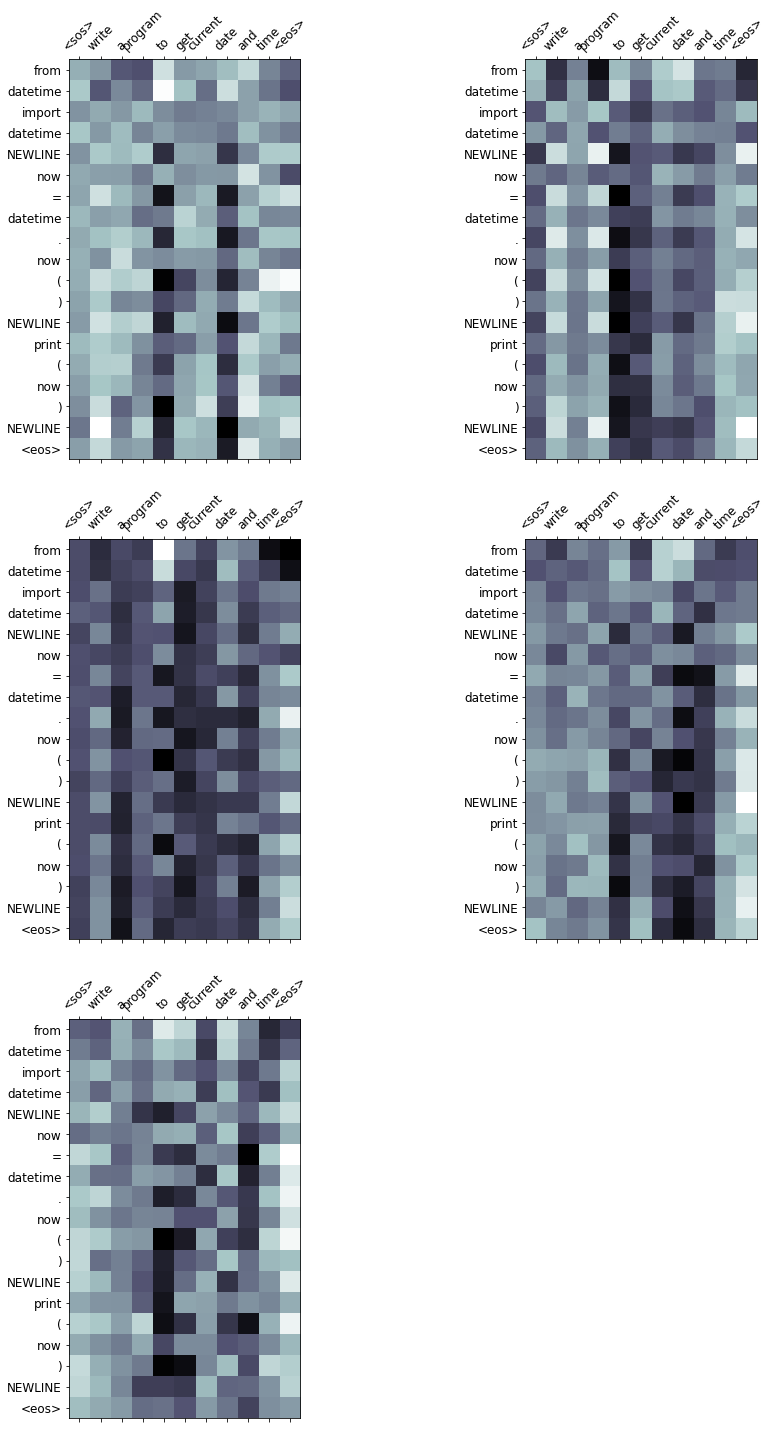

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 25

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'python', 'function', 'to', 'count', 'the', 'number', 'of', 'occurrences', 'in', 'list']
trg = ['def', 'countX', '(', 'lst', ',', 'x', ')', ':', 'NEWLINE', 'INDENT', 'return', 'lst', '.', 'count', '(', 'x', ')', 'NEWLINE', 'DEDENT', 'lst', '=', '[', '8', ',', '6', ',', '8', ',', '10', ',', '8', ',', '20', ',', '10', ',', '8', ',', '8', ']', 'NEWLINE', 'x', '=', '8', 'NEWLINE', 'print', '(', "'{} has occurred {} times'", '.', 'format', '(', 'x', ',', 'countX', '(', 'lst', ',', 'x', ')', ')', ')', 'NEWLINE']


In [ ]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['def', 'countX', '(', 'lst', ',', 'x', ')', ':', 'NEWLINE', 'INDENT', 'count', '=', '0', 'NEWLINE', 'for', 'ele', 'in', 'lst', ':', 'NEWLINE', 'INDENT', 'if', '(', 'ele', '==', 'x', ')', ':', 'NEWLINE', 'INDENT', 'count', '=', 'count', '+', '1', 'NEWLINE', 'DEDENT', 'DEDENT', 'return', 'count', 'NEWLINE', 'DEDENT', 'lst', '=', '[', '8', ',', '8', ',', '10', ',', '8', ',', '8', ',', '8', ',', '8', ',', '8', ',', '10', ',', '8', ',', '8', ',', '8', ',', '8', ',', '8', ',', '8', ',', '8', ',', '10', ',', '8', ']', 'NEWLINE', 'x', '=', '8', 'NEWLINE', 'x', '=', '8', 'NEWLINE', 'print', '(', "'{} has occurred {} times'", '.', 'format', '(', 'x', ',', 'countX', '(', 'x', ')', ')', ')', 'NEWLINE', '<eos>']


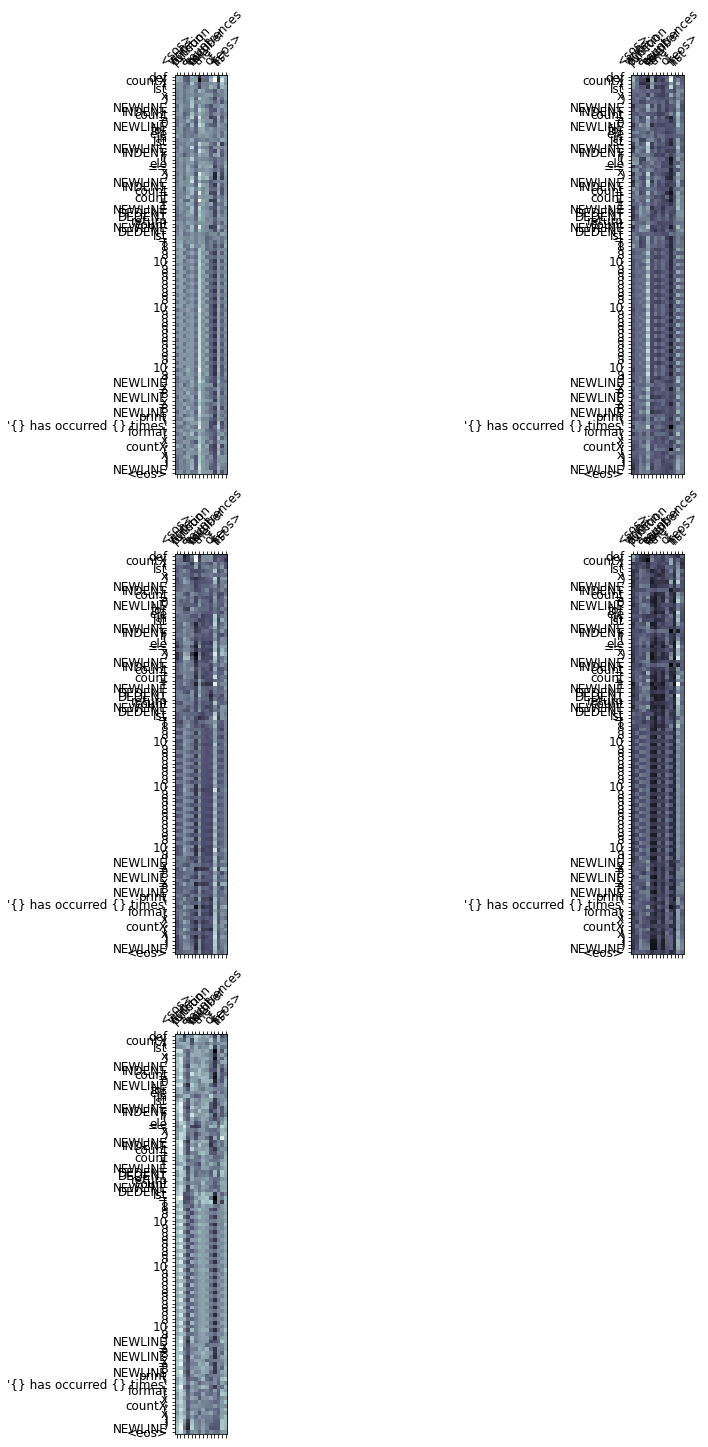

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_dataset.examples[example_idx])['English']
trg = vars(valid_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['86', 'write', 'a', 'program', 'which', 'accepts', 'a', 'string', 'and', 'counts', 'the', 'number', 'of', 'words', 'in', 'it']
trg = ['def', 'num_of_words', '(', 'st', ')', ':', 'NEWLINE', 'INDENT', 'return', 'len', '(', 'st', '.', 'split', '(', ')', ')', 'NEWLINE', 'DEDENT']


In [ ]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['sentence', '=', "'the quick brown fox'", 'NEWLINE', 'print', '(', 'sentence', '[', ':', ':', '2', ']', ')', 'NEWLINE', '<eos>']


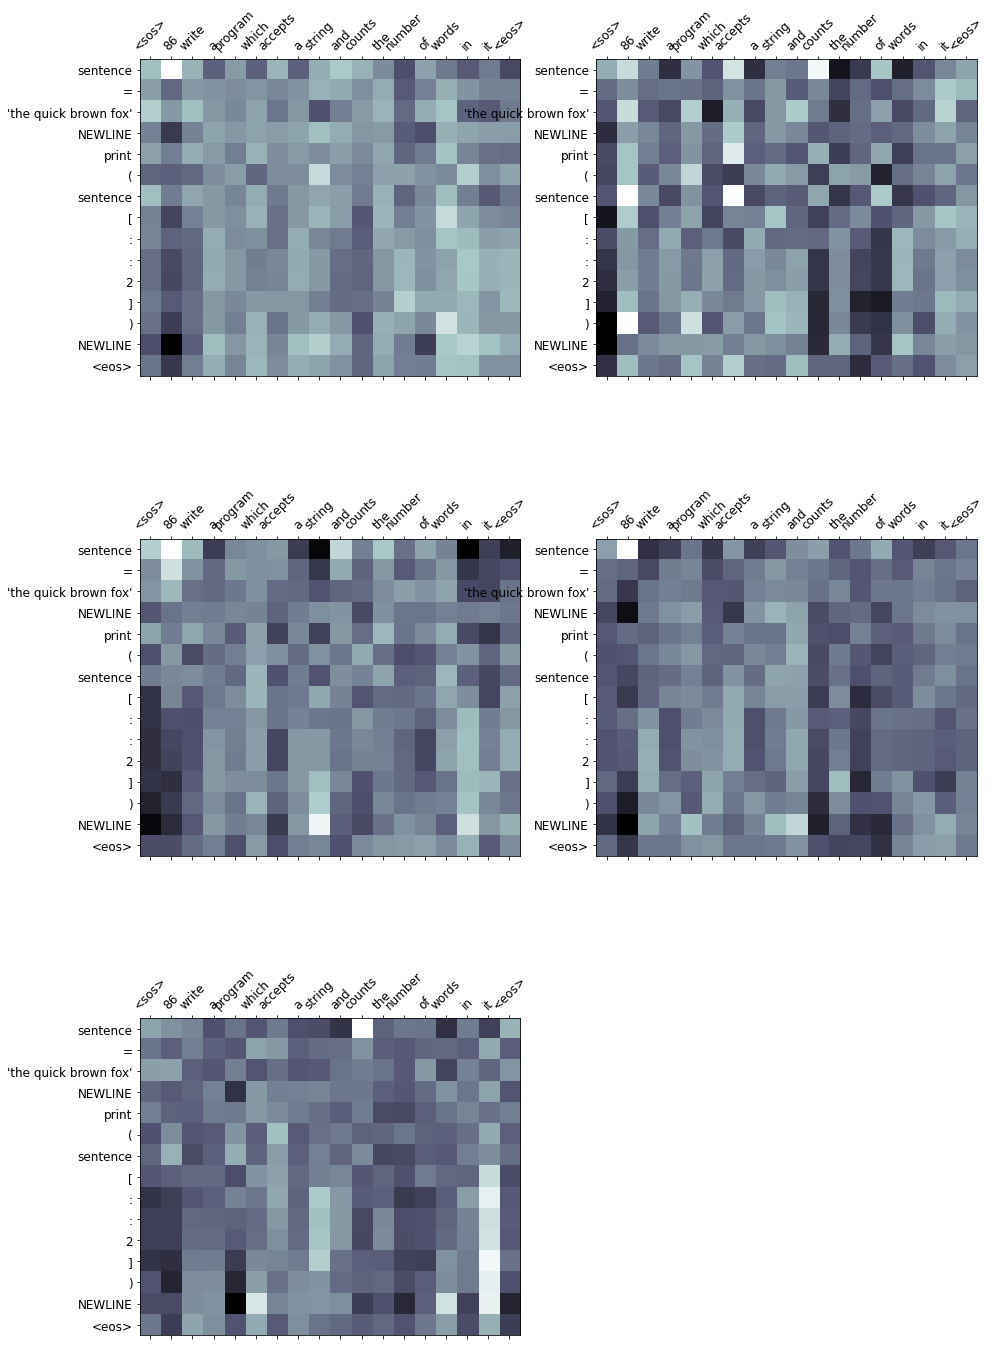

In [ ]:
display_attention(src, translation, attention)


In [ ]:
example_idx = 36

src = vars(valid_dataset.examples[example_idx])['English']
trg = vars(valid_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'function', 'to', 'determine', 'longest', 'increasing', 'subsequence', 'of', 'a', 'list', 'of', 'numbers', 'given']
trg = ['def', 'longest_increaing_subsequence', '(', 'myList', ')', ':', 'NEWLINE', 'INDENT', 'lis', '=', '[', '1', ']', '*', 'len', '(', 'myList', ')', 'NEWLINE', 'elements', '=', '[', '0', ']', '*', 'len', '(', 'myList', ')', 'NEWLINE', 'for', 'i', 'in', 'range', '(', '1', ',', 'len', '(', 'myList', ')', ')', ':', 'NEWLINE', 'INDENT', 'for', 'j', 'in', 'range', '(', '0', ',', 'i', ')', ':', 'NEWLINE', 'INDENT', 'if', 'myList', '[', 'i', ']', '>', 'myList', '[', 'j', ']', 'and', 'lis', '[', 'i', ']', '<', 'lis', '[', 'j', ']', '+', '1', ':', 'NEWLINE', 'INDENT', 'lis', '[', 'i', ']', '=', 'lis', '[', 'j', ']', '+', '1', 'NEWLINE', 'elements', '[', 'i', ']', '=', 'j', 'NEWLINE', 'DEDENT', 'DEDENT', 'DEDENT', 'idx', '=', '0', 'NEWLINE', 'maximum', '=', 'max', '(', 'lis', ')', 'NEWLINE', 'idx', '=', 'lis', '.', 'index', '(', 'maximum', ')', 'NEWLINE', 's

In [ ]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['def', 'add_even_num', '(', 'arr', ')', ':', 'NEWLINE', 'INDENT', 'return', 'sum', '(', 'arr', ')', 'NEWLINE', 'DEDENT', '<eos>']


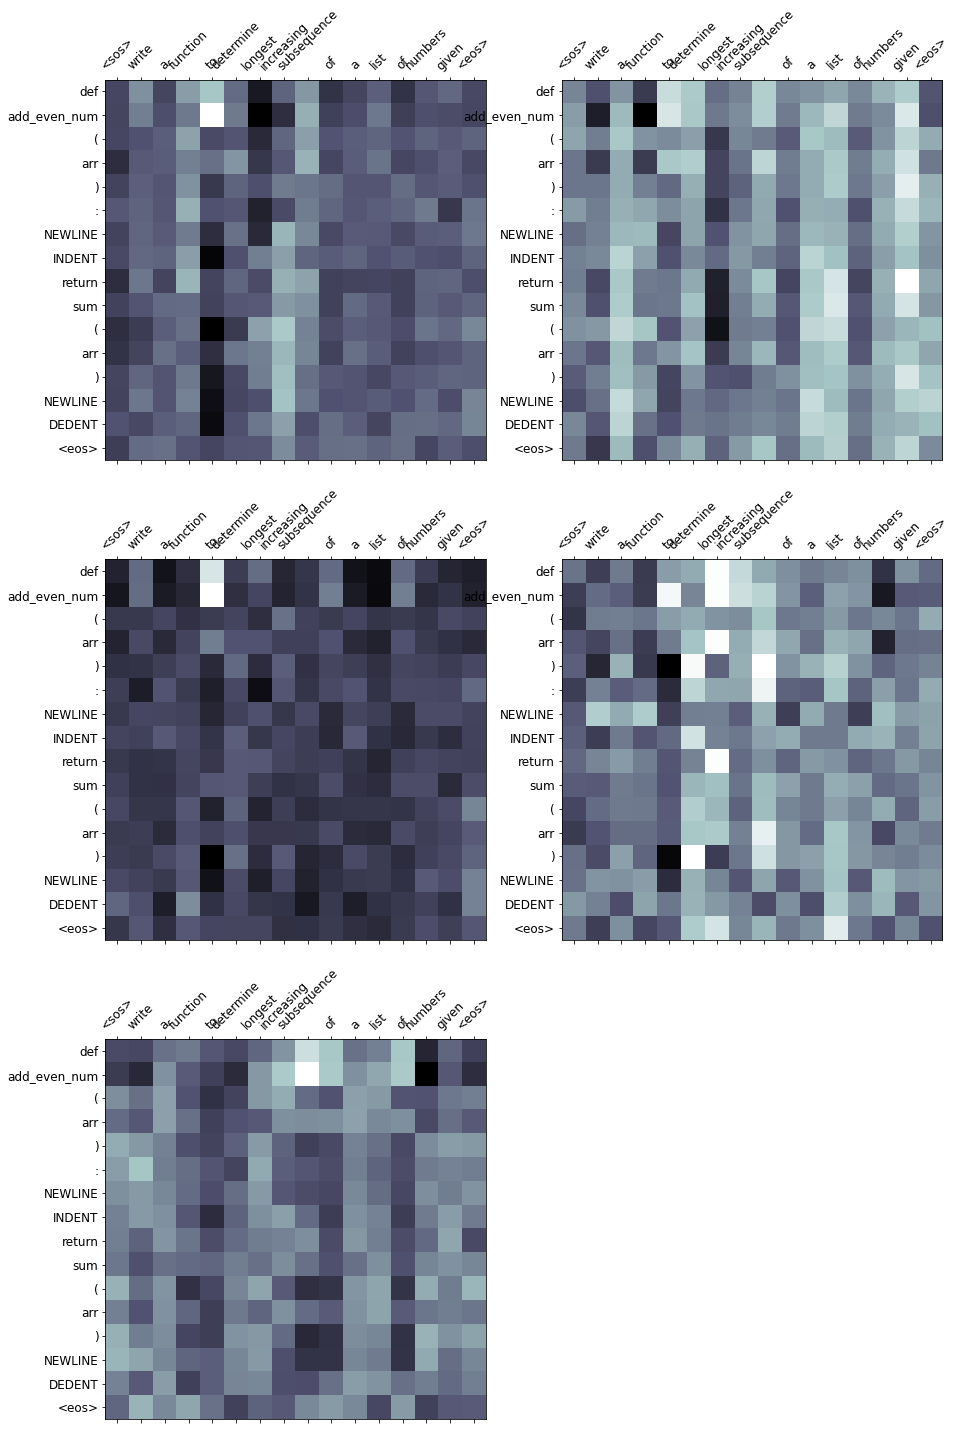

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 59

src = vars(valid_dataset.examples[example_idx])['English']
trg = vars(valid_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'function', 'to', 'return', 'the', 'area', 'of', 'a', 'rhombus', 'with', 'diagonals', 'q1', 'and', 'q2']
trg = ['def', 'cal_area_rhombus', '(', 'q1', ',', 'q2', ')', ':', 'NEWLINE', 'INDENT', 'return', '(', 'q1', '*', 'q2', ')', '/', '2', 'NEWLINE', 'DEDENT']


In [ ]:
translation, translation_type, attention = translate_sentence(src, SRC, TRG, TRG_TYPE, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['def', 'findArea', '(', 'a', ',', 'b', ')', ':', 'NEWLINE', 'INDENT', 'area', '=', '(', 'b', '*', 'a', '*', 'b', '*', 'h', ')', 'NEWLINE', 'return', 'area', 'NEWLINE', 'DEDENT', 'a', '=', '5', 'NEWLINE', 'b', '=', '5', 'NEWLINE', 'print', '(', '"surface area ="', ',', 'surfaceArea', '(', 'a', ',', 'b', ',', 'b', ',', 'h', ')', ')', 'NEWLINE', '<eos>']


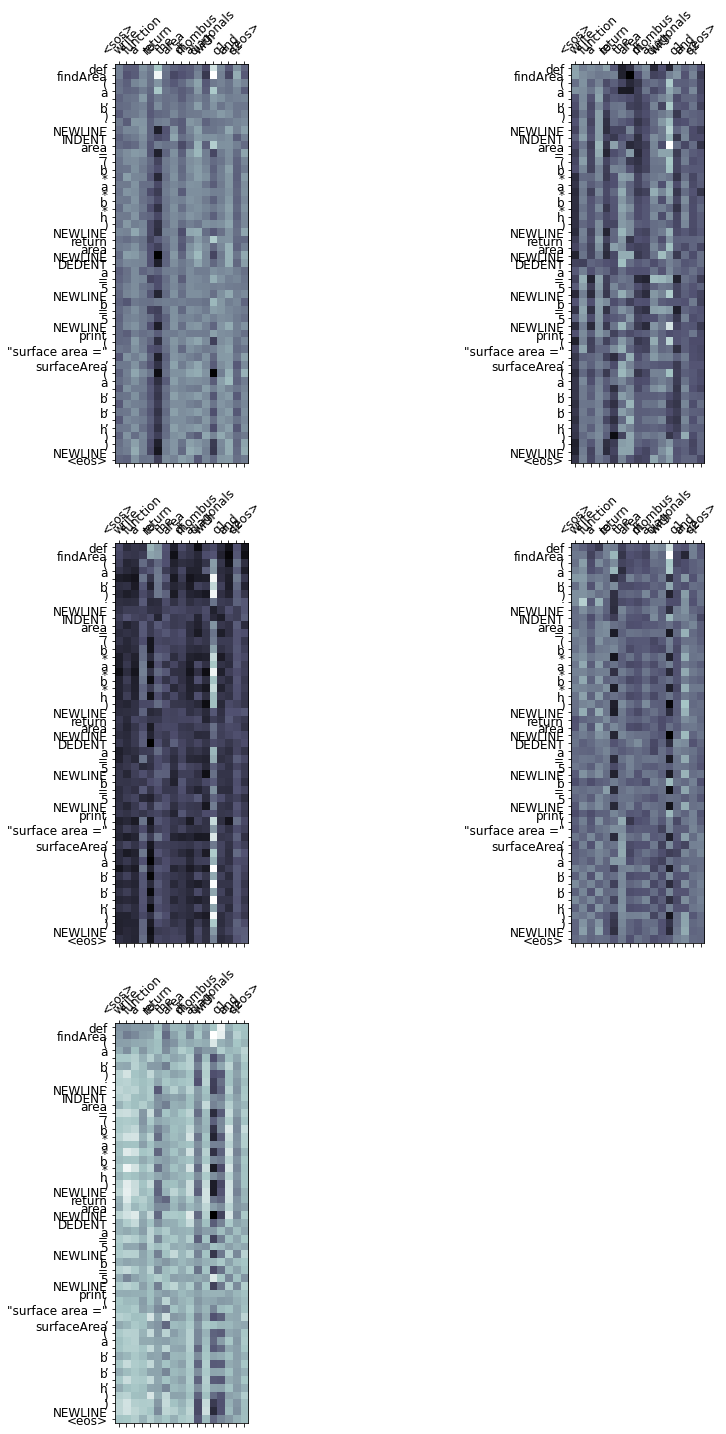

In [ ]:
display_attention(src, translation, attention)

In [ ]:
import math
import collections

from torchtext.data.utils import ngrams_iterator
from torchtext.data.metrics import bleu_score

def _compute_ngram_counter(tokens, max_n):
    """ Create a Counter with a count of unique n-grams in the tokens list
    Args:
        tokens: a list of tokens (typically a string split on whitespaces)
        max_n: the maximum order of n-gram wanted
    Outputs:
        output: a collections.Counter object with the unique n-grams and their
            associated count
    Examples:
        >>> from torchtext.data.metrics import _compute_ngram_counter
        >>> tokens = ['me', 'me', 'you']
        >>> _compute_ngram_counter(tokens, 2)
            Counter({('me',): 2,
             ('you',): 1,
             ('me', 'me'): 1,
             ('me', 'you'): 1,
             ('me', 'me', 'you'): 1})
    """
    assert max_n > 0
    ngrams_counter = collections.Counter(tuple(x.split(' '))
                                         for x in ngrams_iterator(tokens, max_n))

    return ngrams_counter


def bleu_score(candidate_corpus, references_corpus, max_n=4, weights=[0.25] * 4):
    """Computes the BLEU score between a candidate translation corpus and a references
    translation corpus. Based on https://www.aclweb.org/anthology/P02-1040.pdf
    Args:
        candidate_corpus: an iterable of candidate translations. Each translation is an
            iterable of tokens
        references_corpus: an iterable of iterables of reference translations. Each
            translation is an iterable of tokens
        max_n: the maximum n-gram we want to use. E.g. if max_n=3, we will use unigrams,
            bigrams and trigrams
        weights: a list of weights used for each n-gram category (uniform by default)
    Examples:
        >>> from torchtext.data.metrics import bleu_score
        >>> candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
        >>> references_corpus = [[['My', 'full', 'pytorch', 'test'], ['Completely', 'Different']], [['No', 'Match']]]
        >>> bleu_score(candidate_corpus, references_corpus)
            0.8408964276313782
    """

    assert max_n == len(weights), 'Length of the "weights" list has be equal to max_n'
    assert len(candidate_corpus) == len(references_corpus),\
        'The length of candidate and reference corpus should be the same'

    clipped_counts = torch.zeros(max_n)
    total_counts = torch.zeros(max_n)
    weights = torch.tensor(weights)

    candidate_len = 0.0
    refs_len = 0.0

    for (candidate, refs) in zip(candidate_corpus, references_corpus):
        candidate_len += len(candidate)

        # Get the length of the reference that's closest in length to the candidate
        refs_len_list = [float(len(ref)) for ref in refs]
        refs_len += min(refs_len_list, key=lambda x: abs(len(candidate) - x))

        reference_counters = _compute_ngram_counter(refs[0], max_n)
        for ref in refs[1:]:
            reference_counters = reference_counters | _compute_ngram_counter(ref, max_n)

        candidate_counter = _compute_ngram_counter(candidate, max_n)

        clipped_counter = candidate_counter & reference_counters

        for ngram in clipped_counter:
            if len(ngram) > 4:
                continue
            clipped_counts[len(ngram) - 1] += clipped_counter[ngram]

        for ngram in candidate_counter:  # TODO: no need to loop through the whole counter
            if len(ngram) > 4:
                continue
            total_counts[len(ngram) - 1] += candidate_counter[ngram]

    if min(clipped_counts) == 0:
        return 0.0
    else:
        pn = clipped_counts / total_counts
        log_pn = weights * torch.log(pn)
        score = torch.exp(sum(log_pn))

        bp = math.exp(min(1 - refs_len / candidate_len, 0))

        return bp * score.item()
		
		
def calculate_bleu(data, src_field, trg_field, trg_type_field, model, device, max_len = 250):
    
    trgs = []
    pred_trgs = []
    
    for i in range(len(data.examples)):
        
        src = vars(data.examples[i])['English']
        trg = vars(data.examples[i])['Python']

        
        pred_trg, pred_trg_type, _ = translate_sentence(src, src_field, trg_field, trg_type_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        #trgs.append(trg)
        #print("trg=", trg)
        #print("pred_trg=", pred_trg)
        
    #return bleu_score(pred_trgs, trgs,  max_n=1, weights=[1.0] )
    #print("pred_trgs=", pred_trgs)
    #print("trgs=", trgs)
    return bleu_score(pred_trgs, trgs )

In [ ]:
valid_bleu_score = calculate_bleu(valid_dataset, SRC, TRG, TRG_TYPE, model, device)

print(f'Validation BLEU score = {valid_bleu_score*100:.2f}')

Validation BLEU score = 22.28


In [ ]:
test_bleu_score = calculate_bleu(test_dataset, SRC, TRG, TRG_TYPE, model, device)

print(f'Test BLEU score = {test_bleu_score*100:.2f}')

Test BLEU score = 21.69


In [ ]:
#train_bleu_score = calculate_bleu(train_dataset, SRC, TRG, TRG_TYPE, model, device)

#print(f'Train BLEU score = {train_bleu_score*100:.2f}')

In [ ]:
len(test_dataset.examples)

217

In [ ]:
example_idx = 25

src = vars(train_dataset.examples[example_idx])['English']
trg = vars(train_dataset.examples[example_idx])['Python']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'python', 'function', 'to', 'count', 'the', 'number', 'of', 'occurrences', 'in', 'list']
trg = ['def', 'countX', '(', 'lst', ',', 'x', ')', ':', 'NEWLINE', 'INDENT', 'return', 'lst', '.', 'count', '(', 'x', ')', 'NEWLINE', 'DEDENT', 'lst', '=', '[', '8', ',', '6', ',', '8', ',', '10', ',', '8', ',', '20', ',', '10', ',', '8', ',', '8', ']', 'NEWLINE', 'x', '=', '8', 'NEWLINE', 'print', '(', "'{} has occurred {} times'", '.', 'format', '(', 'x', ',', 'countX', '(', 'lst', ',', 'x', ')', ')', ')', 'NEWLINE']


In [ ]:
len(train_dataset.examples)

8495

In [ ]:
def translate_code(token_list):
    num_spaces = 0
    python_code_token_list = ['import pyforest\n']
    if "datetime" in token_list:
        python_code_token_list.append('import datetime\n')

    last_token = ''
    token_list_len = len(token_list)
    for i, token in enumerate(token_list):
        if token in ['<sos>', '<eos>']:
            continue
        elif token == 'NEWLINE':
            python_code_token_list.append('\n')
            if i+1 <token_list_len and token_list[i+1] not in ['INDENT','DEDENT']:
                space_token1 = ' ' * num_spaces
                python_code_token_list.append(space_token1)
        elif token == 'INDENT':
            num_spaces += 4
            if i+1 <token_list_len and token_list[i+1] not in ['INDENT']:
                space_token2 = ' ' * num_spaces
                python_code_token_list.append(space_token2)
        elif token == 'DEDENT':
            num_spaces -= 4
            if num_spaces < 0 :
                num_spaces = 0
            if num_spaces > 0 and  i+1 < token_list_len and token_list[i+1] not in ['DEDENT']:
                space_token3 = ' ' * num_spaces
                python_code_token_list.append(space_token3)
        else:
            if token in [".", '(', ')'] or last_token in ['NEWLINE', 'INDENT', 'DEDENT', '', '.', '(']:
                python_code_token_list.append(token)
            else:
                python_code_token_list.append(' ')
                python_code_token_list.append(token)
        last_token = token

    return ''.join(python_code_token_list)


In [ ]:
import itertools
import sys
import re
import argparse
import subprocess
import difflib

from ast import parse, NodeTransformer, copy_location, Name, FunctionDef, Expr, Str
import astunparse
import editdistance

class NormIdentifiers(NodeTransformer):
    def __init__(self):
        self.identifiers = {}
        super().__init__()

    def visit_Name(self, node):
        try:
            id = self.identifiers[node.id]
        except KeyError:
            id = f'id_{len(self.identifiers)}'
            self.identifiers[node.id] = id
        
        return  copy_location(Name(id=id), node)

class NormFunctions(NodeTransformer):
    def __init__(self, func=None):
        self.identifiers = {}
        self.func = func
        super().__init__()

    def visit_FunctionDef(self, node):
        if self.func and self.func != node.name:
            return None
    
        try:
            name = self.identifiers[node.name]
        except KeyError:
            name = f'function{len(self.identifiers):x}'
            self.identifiers[node.name] = name

        for i, arg in enumerate(node.args.args):
          arg.arg = f'arg{i}'

        new_func = FunctionDef(name=name, args=node.args, body=node.body, decorator_list=node.decorator_list)

        if isinstance(new_func.body[0], Expr) and isinstance(new_func.body[0].value, Str):
            del new_func.body[0]
        
        return  copy_location(new_func, node)

def get_normed_content(filename, func=None):
    if filename.endswith('.py'):
        with open(filename) as src:
            tree = parse(src.read())
        
            tree = NormFunctions(func=func).visit(tree)
            tree = NormIdentifiers().visit(tree)
        
            return (filename, astunparse.unparse(tree))

    if filename.endswith('.c') or filename.endswith('.cpp'):
        asm = subprocess.check_output(['gcc', '-S', '-o-', filename])
        return (filename, asm.decode('utf8'))
		
		
def get_normed_content_str(python_src):
    tree = parse(python_src)
    tree = NormFunctions(func=None).visit(tree)
    tree = NormIdentifiers().visit(tree)
    return astunparse.unparse(tree)


def get_pair_stats(pair):
    dld = editdistance.eval(pair[0][1], pair[1][1])
    avg_len = ( len(pair[0][1]) + len(pair[1][1]) ) / 2.0
    percent = 100.0 * (1 - (dld / avg_len))
    return((percent, dld, pair[0], pair[1]))
	
	
def get_ruby_score(str1, str2):
    edit_distance = editdistance.eval(str1, str2)
    ruby_score = 1 - edit_distance  / (len(str1) + len(str2))
    return ruby_score

In [ ]:
def calculate_ruby_score(data, src_field, trg_field, trg_type_field, model, device, max_len = 250):
    ruby_score_list = []
    failed_count = 0
    for i in range(len(data.examples)):        
        src = vars(data.examples[i])['English']
        trg = vars(data.examples[i])['Python']        
        pred_trg, pred_trg_type, _ = translate_sentence(src, src_field, trg_field, trg_type_field, model, device, max_len)
        try:    
            norm_str_1 = get_normed_content_str(translate_code(trg))
            norm_str_2 = get_normed_content_str(translate_code(pred_trg))
            ruby_score = get_ruby_score(norm_str_1, norm_str_2)
            ruby_score_list.append(ruby_score)
        except Exception:
            failed_count += 1
            traceback.print_exc()
    return sum(ruby_score_list)/len(ruby_score_list), len(data.examples), failed_count

In [ ]:
valid_ruby_score,total_count, failed_count = calculate_ruby_score(valid_dataset, SRC, TRG, TRG_TYPE, model, device)


Traceback (most recent call last):
  File "<ipython-input-107-3011401e37fe>", line 10, in calculate_ruby_score
    norm_str_2 = get_normed_content_str(translate_code(pred_trg))
  File "<ipython-input-106-f0728f4822ea>", line 68, in get_normed_content_str
    tree = parse(python_src)
  File "/usr/lib/python3.7/ast.py", line 35, in parse
    return compile(source, filename, mode, PyCF_ONLY_AST)
  File "<unknown>", line 4
    CI = Amount - principle
     ^
SyntaxError: invalid syntax
Traceback (most recent call last):
  File "<ipython-input-107-3011401e37fe>", line 10, in calculate_ruby_score
    norm_str_2 = get_normed_content_str(translate_code(pred_trg))
  File "<ipython-input-106-f0728f4822ea>", line 68, in get_normed_content_str
    tree = parse(python_src)
  File "/usr/lib/python3.7/ast.py", line 35, in parse
    return compile(source, filename, mode, PyCF_ONLY_AST)
  File "<unknown>", line 10
    if not(student.get('email') == student.get('email') :
                                

In [ ]:
print(f'Valid RUBY score = {valid_ruby_score*100:.2f}')
print(f'Total Count = {total_count}')
print(f'Failed Count = {failed_count}')

Valid RUBY score = 65.39
Total Count = 106
Failed Count = 18


In [ ]:
test_ruby_score,total_count, failed_count = calculate_ruby_score(test_dataset, SRC, TRG, TRG_TYPE, model, device)


Traceback (most recent call last):
  File "<ipython-input-107-3011401e37fe>", line 10, in calculate_ruby_score
    norm_str_2 = get_normed_content_str(translate_code(pred_trg))
  File "<ipython-input-106-f0728f4822ea>", line 68, in get_normed_content_str
    tree = parse(python_src)
  File "/usr/lib/python3.7/ast.py", line 35, in parse
    return compile(source, filename, mode, PyCF_ONLY_AST)
  File "<unknown>", line 8
    res.append(sub [ sub [ sub [ 0 ])
                                    ^
SyntaxError: invalid syntax
Traceback (most recent call last):
  File "<ipython-input-107-3011401e37fe>", line 10, in calculate_ruby_score
    norm_str_2 = get_normed_content_str(translate_code(pred_trg))
  File "<ipython-input-106-f0728f4822ea>", line 68, in get_normed_content_str
    tree = parse(python_src)
  File "/usr/lib/python3.7/ast.py", line 35, in parse
    return compile(source, filename, mode, PyCF_ONLY_AST)
  File "<unknown>", line 6
    (data = data.data.data.data.data.data.data.dat

In [ ]:
print(f'Test RUBY score = {test_ruby_score*100:.2f}')
print(f'Total Count = {total_count}')
print(f'Failed Count = {failed_count}')

Test RUBY score = 64.08
Total Count = 217
Failed Count = 37
